# Projet final d'économétrie : Partie 2 - Séries temporelles

Mohamed SANAD

### Importation des paquets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stat
from scipy.linalg import toeplitz
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score
from tabulate import tabulate

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller, grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.ar_model import AutoReg

In [2]:
# Pour centrer les figures

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### 1. Importer les données du fichier quarterly.xls (corriger le problème éventuel d’observations manquantes).

In [3]:
df = pd.read_excel('quarterly.xls')

print("Nombre d'observations : ", df.shape[0])
print("Nombre de variables : ", df.shape[1])

Nombre d'observations :  212
Nombre de variables :  19


Nous sommes devant des séries temporelles trimestrielles, commençant au premier trimestre de l'année 1960 et se terminant au dernier trimestre de l'année 2012.

In [4]:
if df.isna().any().any():
    print("Le dataframe contient des valeurs manquantes")
else:
    print("Le dataframe ne contient pas de valeurs manquantes")

Le dataframe ne contient pas de valeurs manquantes


### 2. Stationnariser la série de CPI en utilisant la méthode de régression qui inclue un terme de tendance dont la forme fonctionnelle est à choisir (linéaire, quadratique, log, exponentielle, …).

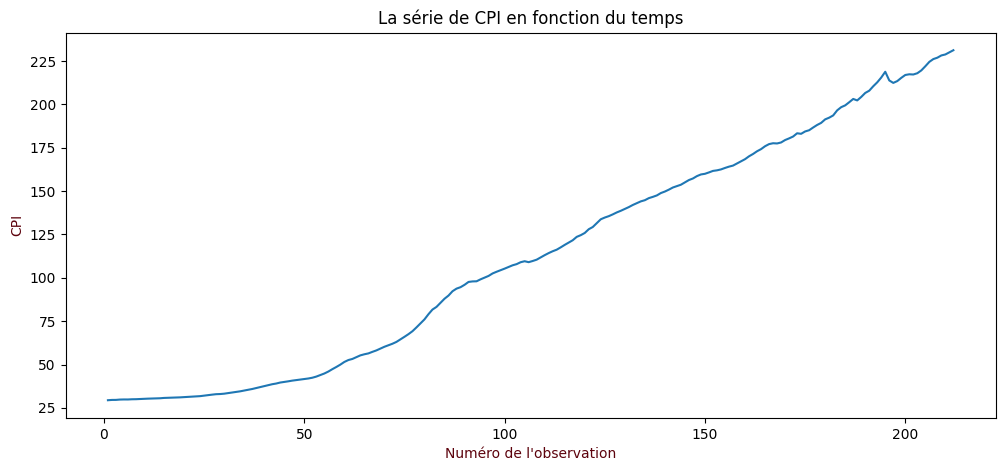

In [5]:
cpi = df['CPI']
t = np.array(range(1, len(cpi)+1))

plt.figure(figsize=(12,5))
plt.plot(t, cpi)
plt.xlabel("Numéro de l'observation", color="#5D030D")
plt.ylabel("CPI", color="#5D030D")
plt.title("La série de CPI en fonction du temps")
plt.show()

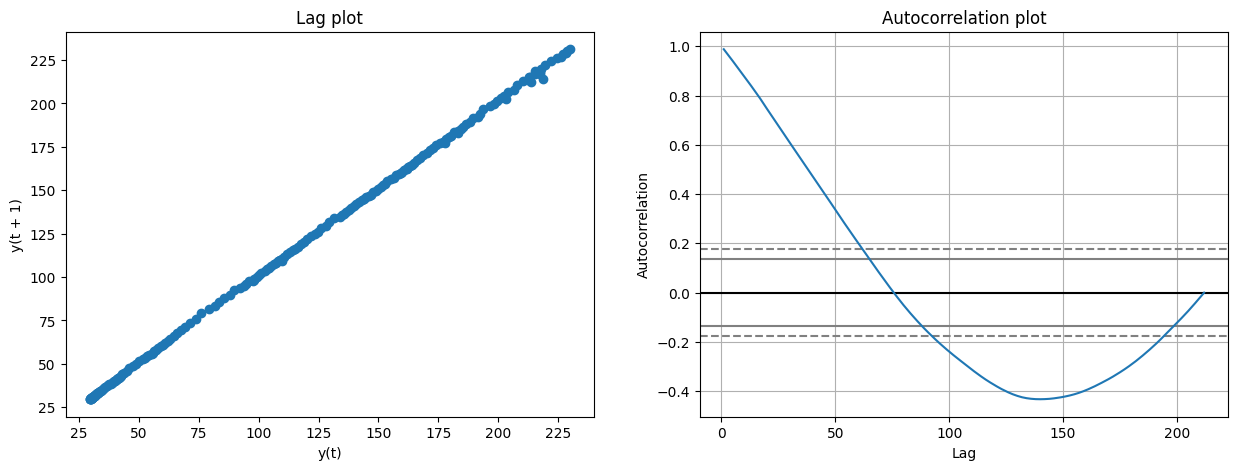

In [6]:
# Lag plot et Autocorrelation plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

pd.plotting.lag_plot(cpi, ax=axes[0])
axes[0].set_title('Lag plot')

pd.plotting.autocorrelation_plot(cpi, ax=axes[1])
axes[1].set_title('Autocorrelation plot')

plt.show()

On peut dire que cette série est non-aléatoire (voir le Lag plot) et non-stationnaire. Premièrement, la moyenne n'est pas constante au cours du temps. Deuxièmement, l'autocorrélogramme (ACF) décroit lentement après le premier lag.

On peut aussi vérifier ça par le test de Dickey-Fuller augmenté (ADF) :

In [7]:
ADF_cpi = adfuller(cpi.values)

print('ADF Statistic: %f' % ADF_cpi[0])
print('p-value: %f' % ADF_cpi[1])
if (ADF_cpi[1] <= 0.05) & (ADF_cpi[4]['5%'] > ADF_cpi[0]):
    print("\u001b[32mLa série cpi est stationnaire\u001b[0m")
else:
    print("\x1b[31mLa série cpi est non-stationnaire\x1b[0m")

ADF Statistic: 1.309868
p-value: 0.996664
La série cpi est non-stationnaire


De plus, on voit que la série de CPI possède une tendance croissante. Cependant, on va comparer entre 3 techniques d'ajustement (linéaire, quadratique et exponentiel) pour choisir la meilleure :

➤ <i>Ajustement linéaire :</i> $y = a + b.x$

➤ <i>Ajustement quadratique :</i> $y = a + b.x + c.x^2$

➤ <i>Ajustement exponentiel :</i> $log(y) = a + b.x$

In [8]:
# Modèle linéaire
model_lin = sm.OLS(cpi, sm.add_constant(t)).fit()
pred_lin = model_lin.predict(sm.add_constant(t))

# Modèle quadratique
model_quad= sm.OLS(cpi, sm.add_constant(np.column_stack((t, t**2)))).fit()
pred_quad = model_quad.predict(sm.add_constant(np.column_stack((t, t**2))))

# Modèle exponentiel
model_exp = sm.OLS(np.log(cpi), sm.add_constant(t)).fit()
pred_exp = np.exp(model_exp.predict(sm.add_constant(t)))

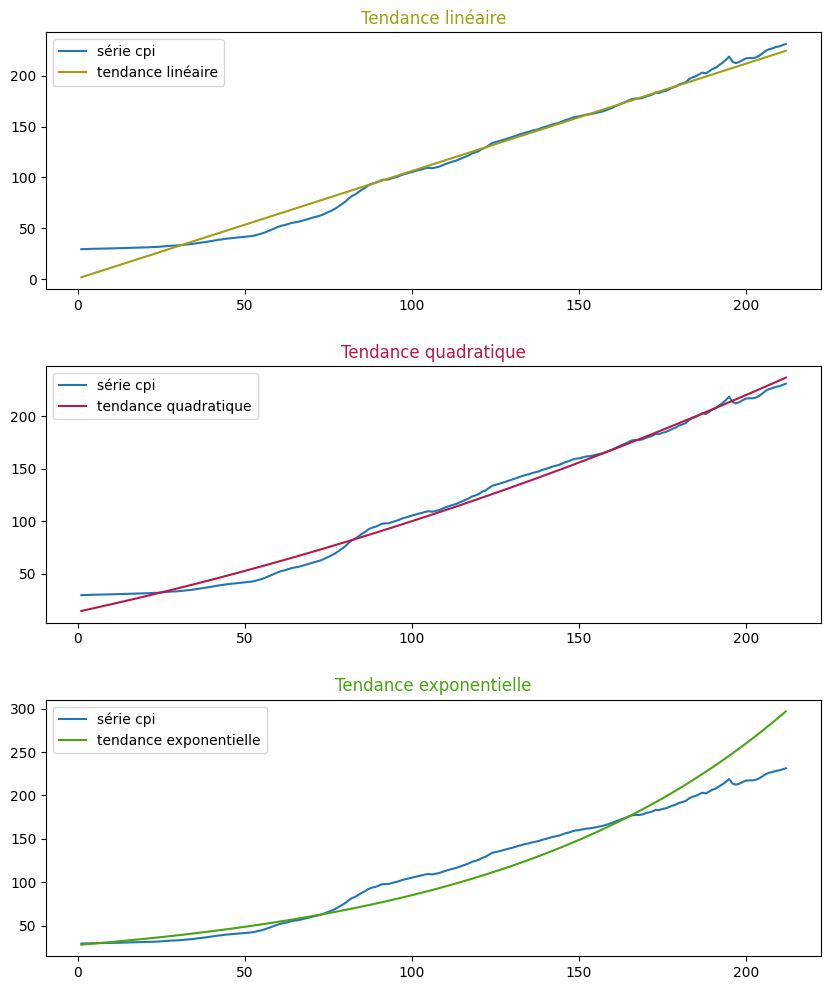

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Tendance linéaire
axes[0].plot(t, cpi, label="série cpi")
axes[0].plot(t, pred_lin, color="#A09E13", label="tendance linéaire")
axes[0].set_title("Tendance linéaire", color="#A09E13")
axes[0].legend()

# Tendance quadratique
axes[1].plot(t, cpi, label="série cpi")
axes[1].plot(t, pred_quad, color="#B91746", label="tendance quadratique")
axes[1].set_title("Tendance quadratique", color="#B91746")
axes[1].legend()

# Tendance exponentielle
axes[2].plot(t, cpi, label="série cpi")
axes[2].plot(t, pred_exp, color="#48A510", label="tendance exponentielle")
axes[2].set_title("Tendance exponentielle", color="#48A510")
axes[2].legend()

plt.subplots_adjust(hspace=0.3)

plt.show()

In [10]:
print(tabulate([["Linéaire", mean_squared_error(cpi, pred_lin)],
                ["Quadratique", mean_squared_error(cpi, pred_quad)],
                ["Exponentielle", mean_squared_error(cpi, pred_exp)]],
               headers=["Tendance", "MSE"]))

Tendance            MSE
-------------  --------
Linéaire        72.8594
Quadratique     40.528
Exponentielle  381.022


On va choisir donc la tendance quadratique car elle minimise le MSE.

Maintenant, et pour stationnariser la série CPI, on va enlever la tendance quadratique :

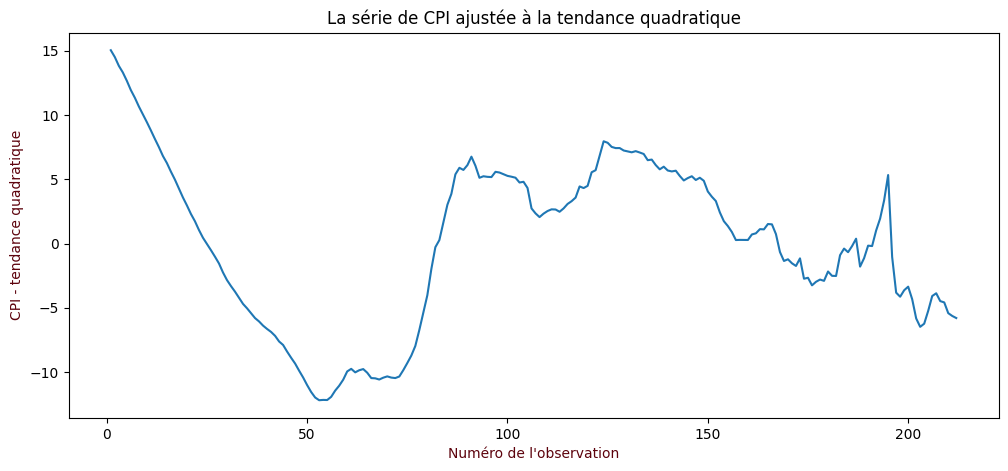

In [11]:
cpi_quad = cpi - pred_quad

plt.figure(figsize=(12,5))
plt.plot(t, cpi_quad)
plt.xlabel("Numéro de l'observation", color="#5D030D")
plt.ylabel("CPI - tendance quadratique", color="#5D030D")
plt.title("La série de CPI ajustée à la tendance quadratique")
plt.show()

On voit bien que cette série est elle aussi non-stationnaire :

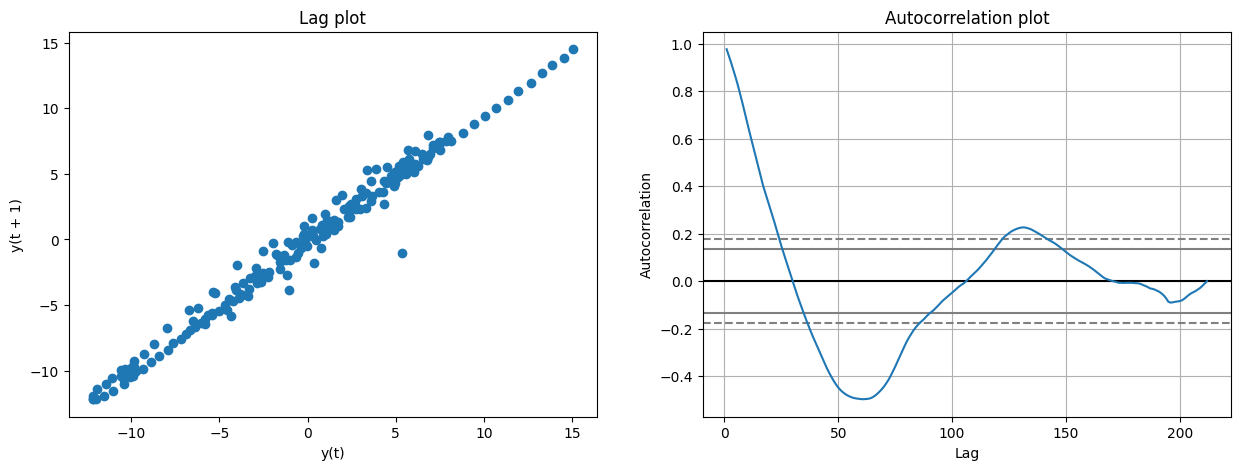

In [12]:
# Lag plot et Autocorrelation plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

pd.plotting.lag_plot(cpi_quad, ax=axes[0])
axes[0].set_title('Lag plot')

pd.plotting.autocorrelation_plot(cpi_quad, ax=axes[1])
axes[1].set_title('Autocorrelation plot')

plt.show()

➜ Diminution lente après le premier lag dans l'autocorrélogramme.

In [13]:
ADF_cpi_quad = adfuller(cpi_quad.values)

print('ADF Statistic: %f' % ADF_cpi_quad[0])
print('p-value: %f' % ADF_cpi_quad[1])
if (ADF_cpi_quad[1] <= 0.05) & (ADF_cpi_quad[4]['5%'] > ADF_cpi_quad[0]):
    print("\u001b[32mLa série cpi ajustée à la tendance quadratique est stationnaire\u001b[0m")
else:
    print("\x1b[31mLa série cpi ajustée à la tendance quadratique est non-stationnaire\x1b[0m")

ADF Statistic: -2.239343
p-value: 0.192277
La série cpi ajustée à la tendance quadratique est non-stationnaire


On doit envisager d'autres méthodes pour stationnariser cette série, comme par exemple, la <b>différenciation</b>. On va donc différencier la série de CPI ajustée à la tendance quadratique :

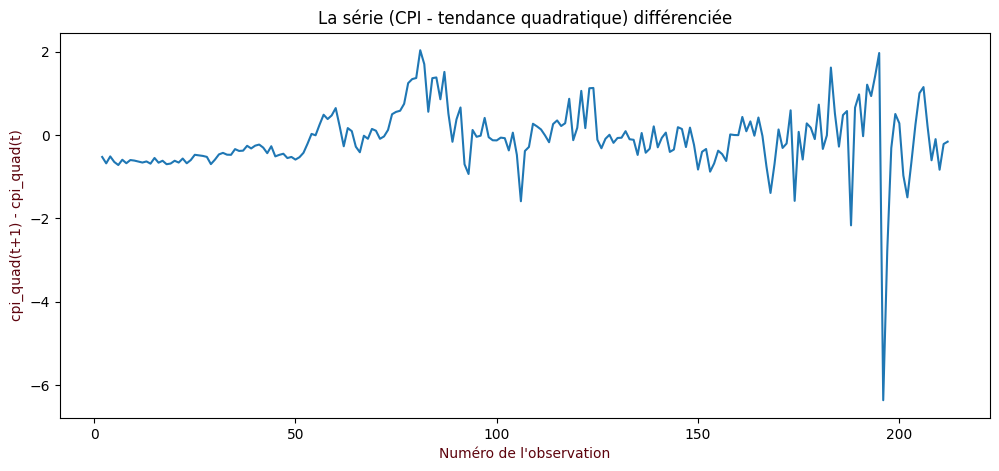

In [14]:
cpi_quad_diff = cpi_quad.diff().iloc[1:]

plt.figure(figsize=(12,5))
plt.plot(t, cpi_quad.diff())
plt.xlabel("Numéro de l'observation", color="#5D030D")
plt.ylabel("cpi_quad(t+1) - cpi_quad(t)", color="#5D030D")
plt.title("La série (CPI - tendance quadratique) différenciée")
plt.show()

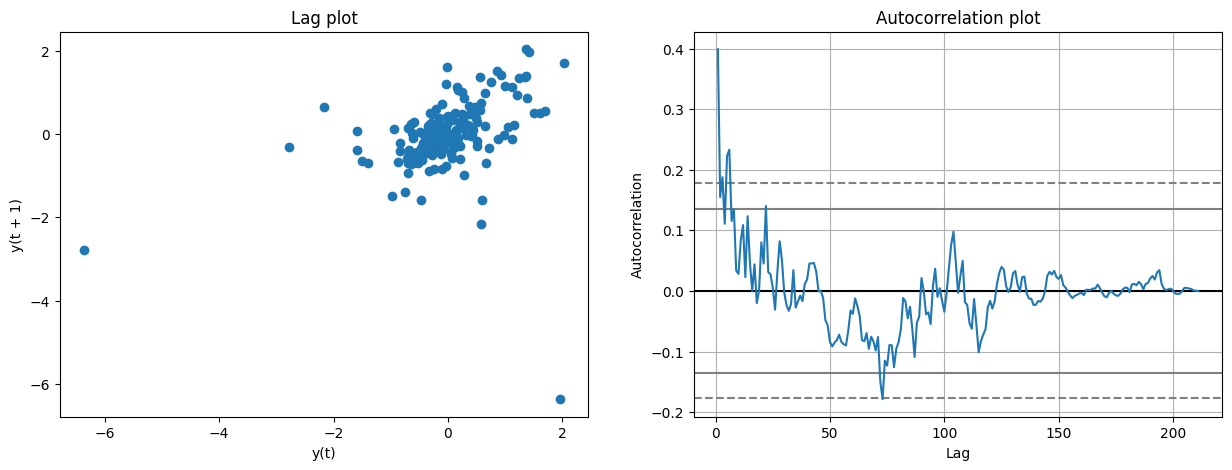

In [15]:
# Lag plot et Autocorrelation plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

pd.plotting.lag_plot(cpi_quad_diff, ax=axes[0])
axes[0].set_title('Lag plot')

pd.plotting.autocorrelation_plot(cpi_quad_diff, ax=axes[1])
axes[1].set_title('Autocorrelation plot')

plt.show()

In [16]:
ADF_cpi_quad_diff = adfuller(cpi_quad_diff.values)

print('ADF Statistic: %f' % ADF_cpi_quad_diff[0])
print('p-value: %f' % ADF_cpi_quad_diff[1])
if (ADF_cpi_quad_diff[1] <= 0.05) & (ADF_cpi_quad_diff[4]['5%'] > ADF_cpi_quad_diff[0]):
    print("\u001b[32mLa série (CPI - tendance quadratique) différenciée est stationnaire\u001b[0m")
else:
    print("\x1b[31mLa série (CPI - tendance quadratique) différenciée est non-stationnaire\x1b[0m")

ADF Statistic: -4.190469
p-value: 0.000684
La série (CPI - tendance quadratique) différenciée est stationnaire


Donc, pour stationnariser notre série CPI, nous avons d'abord évalué les trois techniques d'ajustement et choisi celle qui minimise le MSE, à savoir l'ajustement quadratique, puis nous avons retiré la tendance quadratique, pour finalement différencié la série obtenue (série ajustée de la tendance quadratique).

### 3. Stationnariser la série de CPI en utilisant une moyenne mobile centrée 5x5.

$$ \text{MMC(5 x 5)}_j = \frac{1}{5}\big(\frac{y_{j-4} + y_{j-3} + y_{j-2} + y_{j-1} + y_{j}}{5} + \frac{y_{j-3} + y_{j-2} + y_{j-1} + y_{j} + y_{j+1}}{5} + \frac{y_{j-2} + y_{j-1} + y_{j} + y_{j+1} + y_{j+2}}{5} + \frac{y_{j-1} + y_{j} + y_{j+1} + y_{j+2} + y_{j+3}}{5} + \frac{y_{j} + y_{j+1} + y_{j+2} + y_{j+3} + y_{j+4}}{5}\big) $$

<br>

$$ \text{MMC(5 x 5)}_j = \frac{1}{25}.y_{j-4} + \frac{2}{25}.y_{j-3} + \frac{3}{25}.y_{j-2} + \frac{4}{25}.y_{j-1} + \frac{5}{25}.y_{j} + \frac{4}{25}.y_{j+1} + \frac{3}{25}.y_{j+2} +\frac{2}{25}.y_{j+3} + \frac{1}{25}.y_{j+4} $$

In [17]:
cpi = df['CPI']
t = np.array(range(1, len(cpi)+1))

rol_mean_5_5 = cpi.rolling(window=5, center=True).mean().rolling(window=5, center=True).mean()

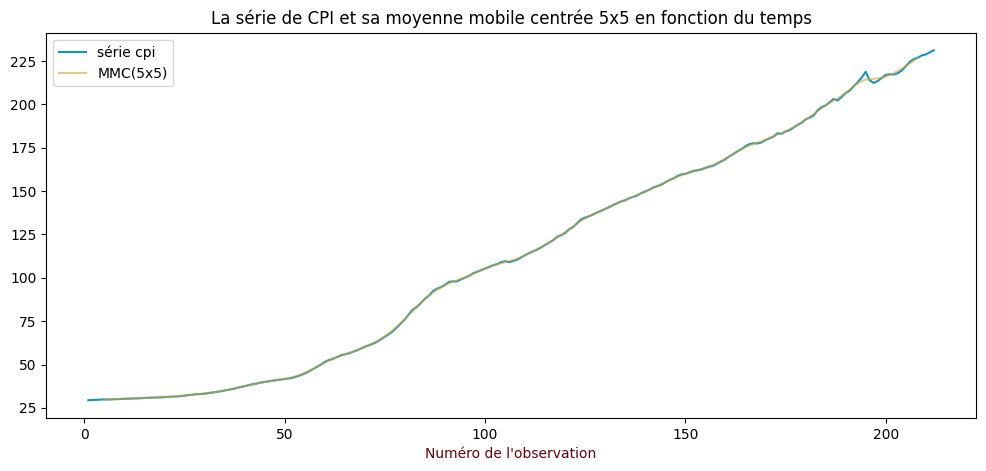

In [18]:
plt.figure(figsize=(12,5))
plt.plot(t, cpi, label="série cpi", color="#1792BD")
plt.plot(t, rol_mean_5_5, label="MMC(5x5)", color="#D0A836", alpha=0.6)
plt.xlabel("Numéro de l'observation", color="#5D030D")
plt.title("La série de CPI et sa moyenne mobile centrée 5x5 en fonction du temps")
plt.legend()
plt.show()

Pour stationnariser la série CPI, on va enlever cette moyenne mobile centrée :

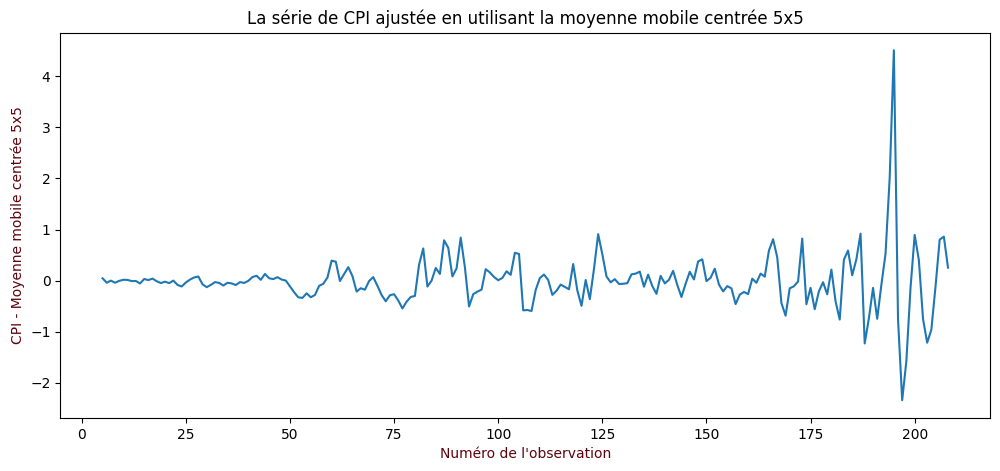

In [19]:
cpi_rol_mean_5_5 = cpi - rol_mean_5_5

plt.figure(figsize=(12,5))
plt.plot(t, cpi_rol_mean_5_5)
plt.xlabel("Numéro de l'observation", color="#5D030D")
plt.ylabel("CPI - Moyenne mobile centrée 5x5", color="#5D030D")
plt.title("La série de CPI ajustée en utilisant la moyenne mobile centrée 5x5")
plt.show()

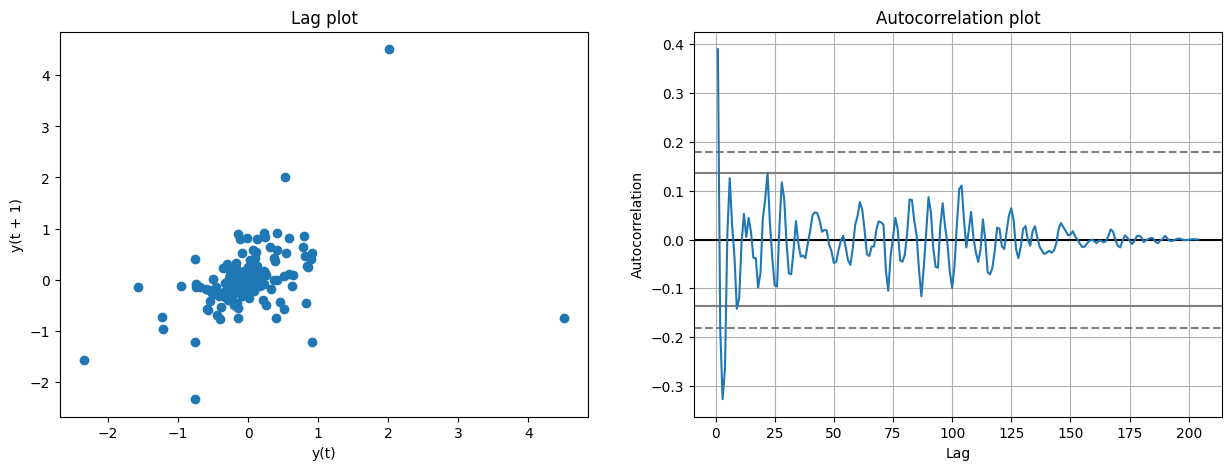

In [20]:
cpi_rol_mean_5_5 = cpi_rol_mean_5_5[4:-4]

# Lag plot et Autocorrelation plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

pd.plotting.lag_plot(cpi_rol_mean_5_5, ax=axes[0])
axes[0].set_title('Lag plot')

pd.plotting.autocorrelation_plot(cpi_rol_mean_5_5, ax=axes[1])
axes[1].set_title('Autocorrelation plot')

plt.show()

L'autocorrélogramme décroit rapidement après le premier pic. La série parait donc stationnaire.

In [21]:
ADF_cpi_rol_mean_5_5 = adfuller(cpi_rol_mean_5_5.values)

print('ADF Statistic: %f' % ADF_cpi_rol_mean_5_5[0])
print('p-value: %f' % ADF_cpi_rol_mean_5_5[1])
if (ADF_cpi_rol_mean_5_5[1] <= 0.05) & (ADF_cpi_rol_mean_5_5[4]['5%'] > ADF_cpi_rol_mean_5_5[0]):
    print("\u001b[32mLa série (CPI - moyenne mobile centrée 5x5) est stationnaire\u001b[0m")
else:
    print("\x1b[31mLa série (CPI - moyenne mobile centrée 5x5) est non-stationnaire\x1b[0m")

ADF Statistic: -7.058513
p-value: 0.000000
La série (CPI - moyenne mobile centrée 5x5) est stationnaire


### 4. Calculer inf, le taux d’inflation à partir de la variable CPI. Faire un graphique dans le temps de inf. Commentez.

Pour calculer le taux d'inflation à partir de la variable CPI (Indice des prix à la consommation), on va utiliser la formule suivante :

$$ inf = \frac{CPI_{actuel} - CPI_{précédent}}{CPI_{actuel}} x 100 $$

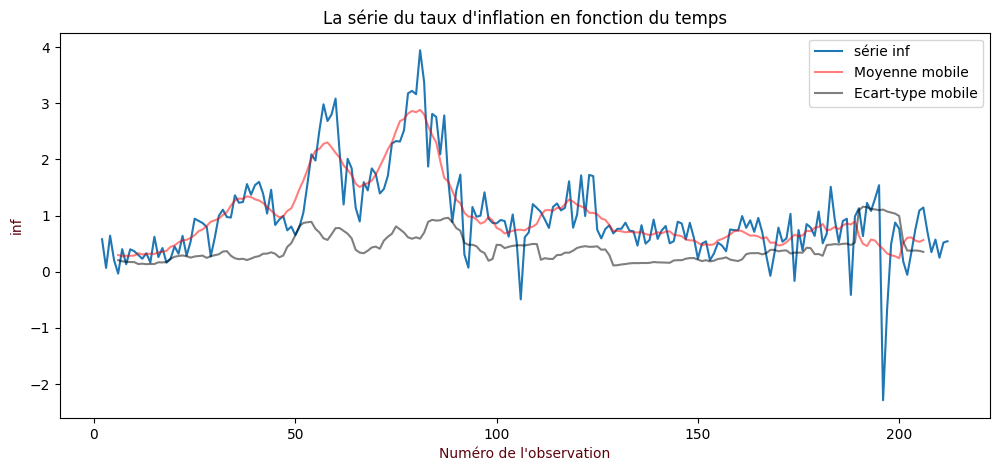

In [22]:
inf = ((cpi.diff() / cpi.shift()) * 100.0).rename('INF')

rolmean = inf.rolling(window=11, center=True).mean()
rolstd = inf.rolling(window=11, center=True).std()

plt.figure(figsize=(12,5))

plt.plot(t, inf, label="série inf")
plt.plot(rolmean, color='red', label='Moyenne mobile', alpha=0.5)
plt.plot(rolstd, color='black', label = 'Ecart-type mobile', alpha=0.5)

plt.xlabel("Numéro de l'observation", color="#5D030D")
plt.ylabel("inf", color="#5D030D")
plt.title("La série du taux d'inflation en fonction du temps")

plt.legend()

plt.show()

Il n'y a pas de motifs saisonniers à signaler dans cette courbe. Cependant, on peut pas juger si la série est stationnaire ou pas. Quand on voit cette courbe, nous avons la moyenne qui n'est pas constante au fil du temps, et l'écart-type qui est plus ou moins constant.

### 5. Interpréter l'autocorrélogramme et l'autocorrélogramme partiel de inf. Quelle est la différence entre ces deux graphiques ?

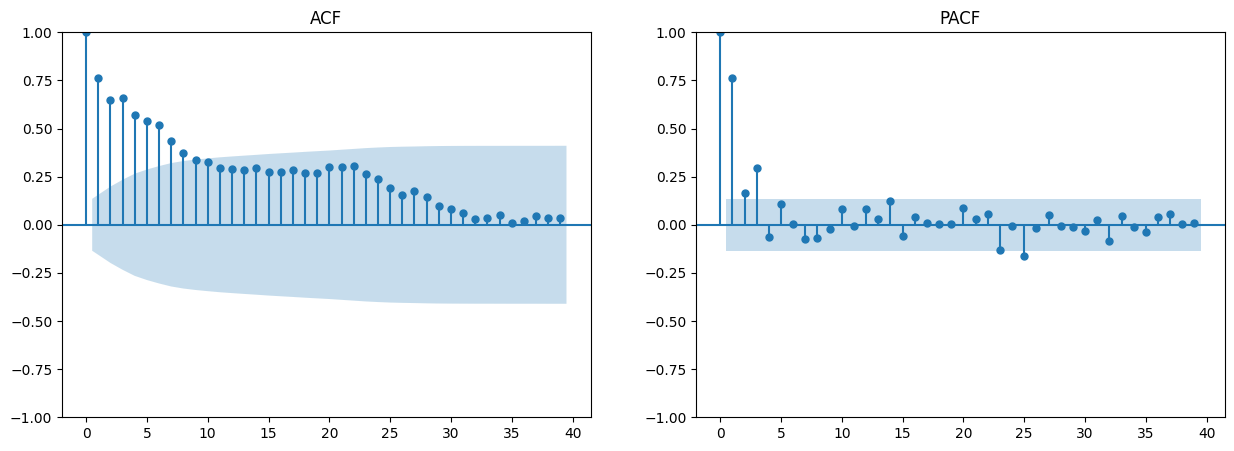

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(inf.dropna(), lags=range(0,40), ax=axes[0])
axes[0].set_title('ACF')

plot_pacf(inf.dropna(), lags=range(0,40), method='ywm', ax=axes[1])
axes[1].set_title('PACF')

plt.show()

On remarque que l'autocorrélogramme décroit lentement après le premier lag, et on constate aussi 2 pics significatifs dans l'autocorrélogramme partiel

<br>

<b>Différence entre les deux :</b>

➤ <i>Fonction d'autocorrelation et d'autocorrelation partielle :</i>

L'autocorrélation (ou l'autocovariance) d'une série fait référence au fait que dans une série temporelle ou spatiale, la mesure d'un phénomène à un instant t peut être corrélée aux mesures précédentes (au temps t − 1, t − 2, t − 3, etc.) ou aux mesures suivantes (à t + 1, t + 2, t + 3, ...). Une série autocorrélée est ainsi corrélée à elle-même, avec un décalage (lag) donné.

Pour un lag s : $Autocorrélation~(s) = Cov(X_t, X_{t-s})~/~{Var(X_t)}$

L'autocorrélation partielle permet de mesurer l'autocorrélation d'un signal pour un décalage k "indépendamment" des autocorrélations pour les décalages inférieurs. Par exemple, si on a une forte autocorrélation pour un décalage de 3, de 6, de 9... l'autocorrélation pour le décalage de 6 et 9 pourrait très bien être une conséquence de celle existant pour le décalage de 3.

En effet, l'autocorrélation partielle représente la corrélation entre $X_t$ et les résidus de la regression de $X_t$ sur ses versions décallées d’ordre $[1, ..., s]. Donc, si on effectue la régression :

$$ X_t = β_0 + β_1.X_{t-1} + β_2.X_{t-2} + ... + β_s.X_{t-s} + ε $$

Alors : $Autocorrélation~partielle~(s) = Cov(X_t, ε_t)~/~{Var(X_t)}$

Les deux graphiques, l'autocorrélogramme et l'autocorrélogramme partiel, jouent un rôle crucial dans la modélisation des séries temporelles à l'aide du modèle <b>ARIMA (Autoregressive Integrated Moving Average)</b>.

● Sélection de l'ordre AR : L'autocorrélogramme peut aider à déterminer l'ordre autoregressif (AR) du modèle ARIMA. Les pics significatifs dans l'autocorrélogramme indiquent les décalages temporels où les observations sont corrélées. En identifiant les décalages significatifs, on peut choisir le nombre optimal de termes AR pour capturer les dépendances temporelles dans les données.

● Sélection de l'ordre MA : L'autocorrélogramme partiel est utile pour sélectionner l'ordre de la moyenne mobile (MA) du modèle ARIMA. Il permet d'identifier les décalages significatifs dans la corrélation partielle, qui indiquent les dépendances directes entre les observations. Les pics significatifs dans l'autocorrélogramme partiel aident à déterminer le nombre optimal de termes MA pour modéliser les erreurs résiduelles.

### 6. Quelle est la différence entre la stationnarité et l'ergodicité ? Pourquoi a-t-on besoin de ces deux conditions. Expliquez le terme "spurious regression".

Une série temporelle est fortement stationnaire si la loi de distribution jointe de $x_{t-k}, ... , x_t, ... , x_{t+k} $ ne dépend pas du temps. On définit aussi la stationnarité faible lorsque les moments d’ordre 1 et 2 d’une série temporelle ne dépendent pas du temps.

Un processus ergodique est un processus stochastique pour lequel les statistiques peuvent être approchées par l’étude d’une seule réalisation suffisamment longue. Un processus non ergodique change de façon ératique à un rythme inconsistant. L'ergodicité assure que les moyennes temporelles sont identiques aux moyennes statistiques, ce qui permet de connaître entièrement la statistique à partir d'une seule réalisation.

La "spurious regression" (régression fallacieuse) est un phénomène statistique dans lequel deux séries temporelles présentent une corrélation élevée alors qu'elles ne sont pas liées causalement. Cela signifie qu'il peut sembler y avoir une relation significative entre les deux séries, mais en réalité, cette relation est due au hasard et non à une relation de cause à effet ou à une dépendance réelle.

La régression fallacieuse peut se produire lorsque deux séries temporelles présentent une tendance à long terme, c'est-à-dire qu'elles augmentent ou diminuent au fil du temps, même si elles n'ont aucune relation causale directe. Lorsque ces deux séries sont régressées l'une sur l'autre, il peut sembler qu'il existe une corrélation significative, mais en réalité, cette corrélation est simplement due à la présence de tendances similaires dans les deux séries.

### 7. Faire le test Augmented Dickey Fuller pour inf en utilisant utilisant le critère AIC pour déterminer le nombre de lags à inclure. Commenter.

In [24]:
ADF_inf = adfuller(inf.dropna().values)

print(tabulate([["ADF Statistic", ADF_inf[0]], ["p-value", ADF_inf[1]], ["n_lags", ADF_inf[2]], 
                ["n_points_used", ADF_inf[3]], ["Critical value at 1%", ADF_inf[4]["1%"]], 
                ["Critical value at 5%", ADF_inf[4]["5%"]], ["Critical value at 10%", ADF_inf[4]["10%"]], 
                ["Maximized information criterion", ADF_inf[5]]]))

if (ADF_inf[1] <= 0.05) & (ADF_inf[4]['5%'] > ADF_inf[0]):
    print("\u001b[32mLa série du taux d'inflation est stationnaire\u001b[0m")
else:
    print("\x1b[31mLa série du taux d'inflation est non-stationnaire\x1b[0m")

-------------------------------  -----------
ADF Statistic                     -2.91906
p-value                            0.0431765
n_lags                             2
n_points_used                    208
Critical value at 1%              -3.46219
Critical value at 5%              -2.87554
Critical value at 10%             -2.57423
Maximized information criterion  276.758
-------------------------------  -----------
La série du taux d'inflation est stationnaire


Le test augmenté de Dickey-Fuller est un test statistique qui vise à savoir si une série temporelle est stationnaire, c'est-à-dire si ses propriétés statistiques (espérance, variance, auto-corrélation) varient ou pas dans le temps.

$H_0 :$ La série n'est pas stationnaire
<br>$H_1 :$ La série est stationnaire

Pour un seuil de signficativité de 5%, l’hypothèse nulle de racine unitaire n’est pas rejetée. La série 'inf' est donc stationnaire.

### 8. Proposer une modélisation AR(p) de inf, en utilisant tous les outils vus au cours.

Un processus $AR(p)$ s'écrit comme suit :

$$ X_t = β_0 + β_1.X_{t-1} + β_2.X_{t-2} + ... + β_p.X_{t-p} + ε_t $$

Pour déterminer le nombre p de termes à inclure, on utilisera la fonction d'autocorrélation partielle. On peut voir une zone bleue dans les graphiques ACF et PACF. Cette zone bleue représente l'intervalle de confiance à 95 % et est un indicateur du seuil de signification. En d'autres termes, tout ce qui se trouve dans la zone bleue est statistiquement proche de zéro et tout ce qui se trouve en dehors de la zone bleue est statistiquement non nul.

Pour déterminer p, on répond à la question :

<i>"Combien de pics sont au-dessus ou au-dessous de l'intervalle de confiance avant que le pic suivant n'entre dans la zone bleue ?"</i>

La réponse est : <b>3</b>

Nous avons donc : $$ X_t = β_0 + β_1.X_{t-1} + β_2.X_{t-2} + β_3.X_{t-3} + ε_t $$

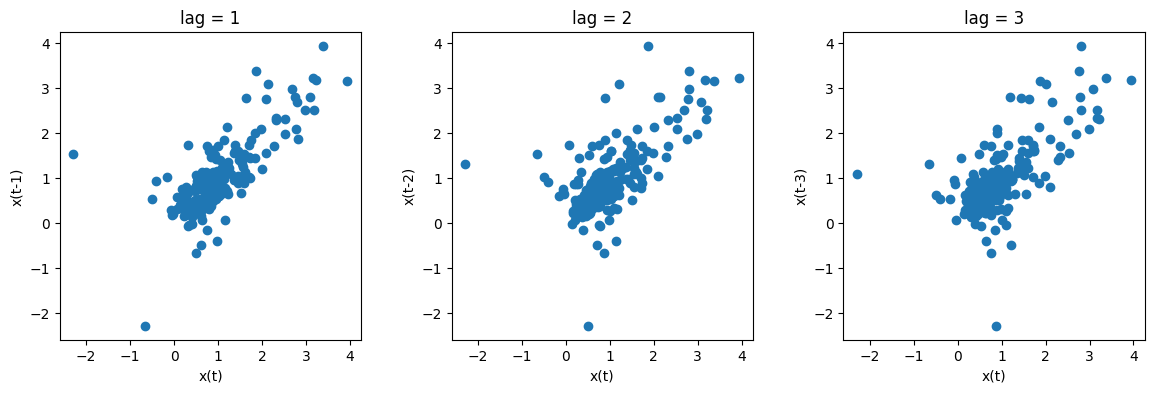

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4))

for i, ax in enumerate(axes.flat):
    ax.scatter(inf, inf.shift(i+1))
    ax.set_title(f'lag = {i+1}')
    ax.set_xlabel('x(t)')
    ax.set_ylabel(f'x(t-{i+1})')
    
plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
plt.show()

On peut aussi choisir le modèle qui minimise le critère BIC <i>(Bayesian information criterion)</i> :

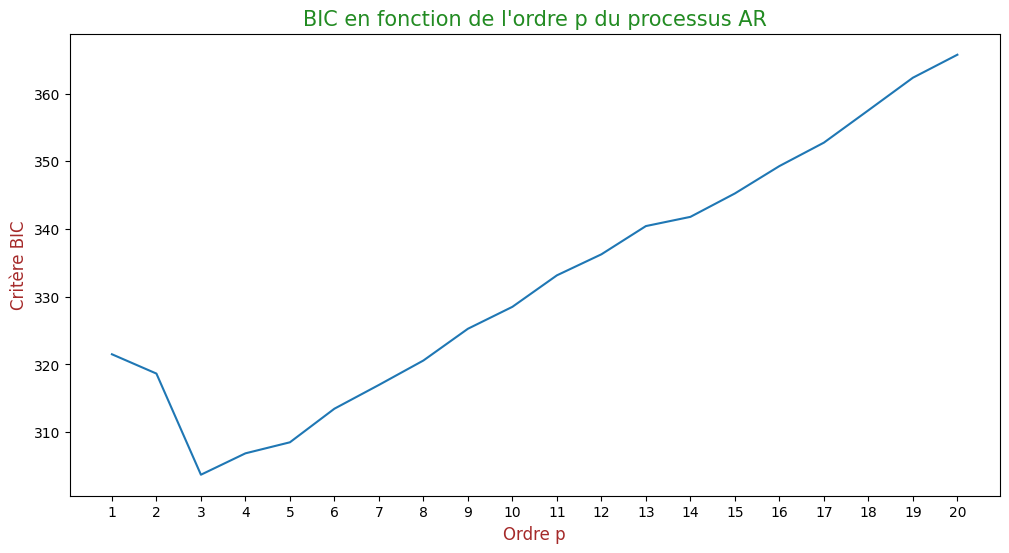

lag optimal selon le critère BIC: 3


In [26]:
BIC = []

for lag in range(1, 21):
    AR_model = AutoReg(inf.dropna().values, lags=lag).fit()
    
    BIC.append(AR_model.bic)

plt.figure(figsize=(12, 6))
plt.plot(range(1, 21), BIC, label='BIC')
plt.xlabel("Ordre p", fontsize="12", color='brown')
plt.ylabel("Critère BIC", fontsize=12, color='brown')
plt.title("BIC en fonction de l'ordre p du processus AR", fontsize=15, color='forestgreen')
plt.xticks(range(1,21))
plt.show()

print(f"lag optimal selon le critère BIC: {np.argmin(BIC) + 1}")

### 9. Estimer le modèle de la courbe de Philips qui explique le taux de chômage (Unemp) en fonction du taux d’inflation courant et une constante.

La courbe de Phillips est une courbe reliant négativement l'inflation et le taux de chômage d'une économie. Autrement dit, cette courbe indique que plus les prix augmentent, moins il y a de chômeurs et inversement.

Le raisonnement explicatif derrière la courbe de Philips se fonde sur une analyse du pouvoir de négociation des salariés. Lorsque les entreprises embauchent, le chômage baisse ; or, cela augmente le pouvoir de négociation des salariés, qui poussent les salaires à la hausse. Or, cela provoque une augmentation des prix (de l'inflation), ce qui réduit relativement le salaire des salariés : le salaire réel chute car les salariés n'obtiennent pas immédiatement d'augmentation de leur salaire. Ainsi, le salaire réel étant plus faible, les entreprises augmentent leurs embauches, ce qui fait à nouveau baisser le chômage.

In [27]:
cpi = df['CPI']
t = np.array(range(1, len(cpi)+1))
inf = ((cpi.diff() / cpi.shift()) * 100.0).rename('INF')
unemp = df['Unemp']

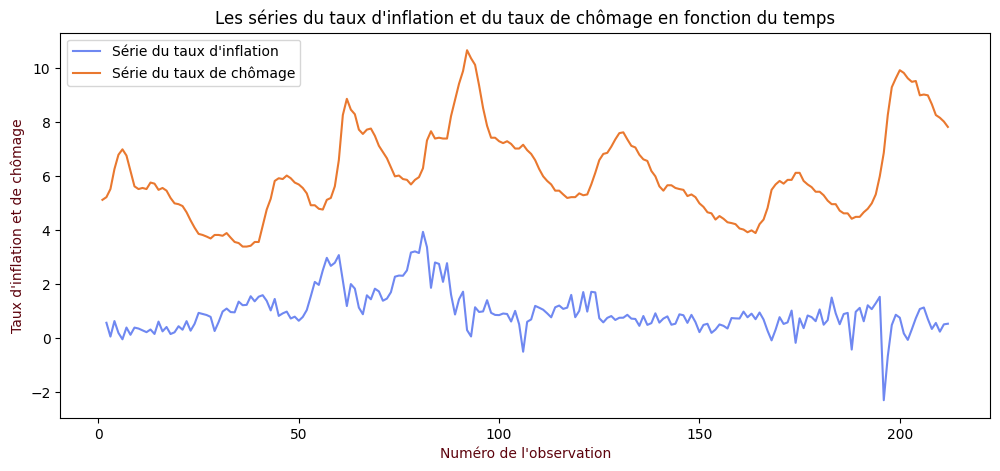

In [28]:
plt.figure(figsize=(12,5))
plt.plot(t, inf, label="Série du taux d'inflation", color="#6F88F1")
plt.plot(t, unemp, label="Série du taux de chômage", color="#E9782F")
plt.xlabel("Numéro de l'observation", color="#5D030D")
plt.ylabel("Taux d'inflation et de chômage", color="#5D030D")
plt.title("Les séries du taux d'inflation et du taux de chômage en fonction du temps")
plt.legend()
plt.show()

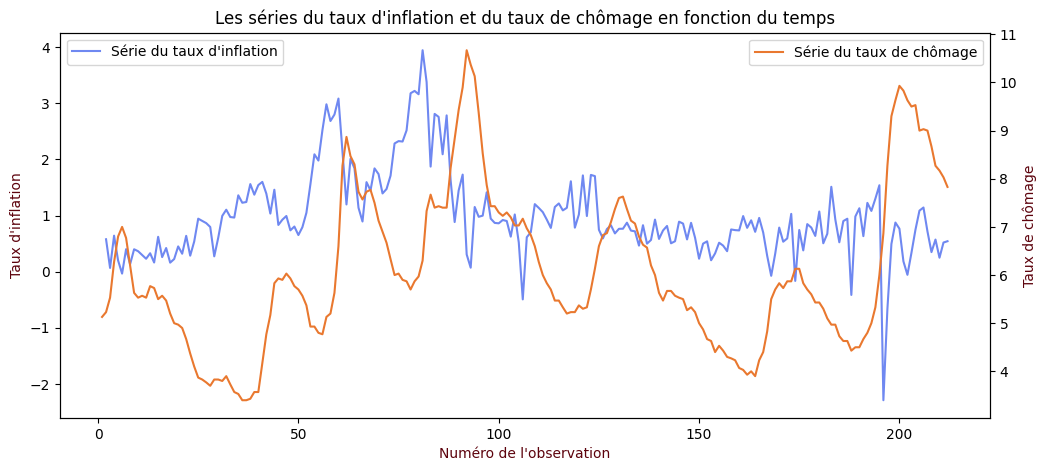

In [29]:
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(t, inf, label="Série du taux d'inflation", color="#6F88F1")
ax1.set_xlabel("Numéro de l'observation", color="#5D030D")
ax1.set_ylabel("Taux d'inflation", color="#5D030D")

ax2 = ax1.twinx()
ax2.plot(t, unemp, label="Série du taux de chômage", color="#E9782F")
ax2.set_ylabel("Taux de chômage", color="#5D030D")

ax1.set_title("Les séries du taux d'inflation et du taux de chômage en fonction du temps")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

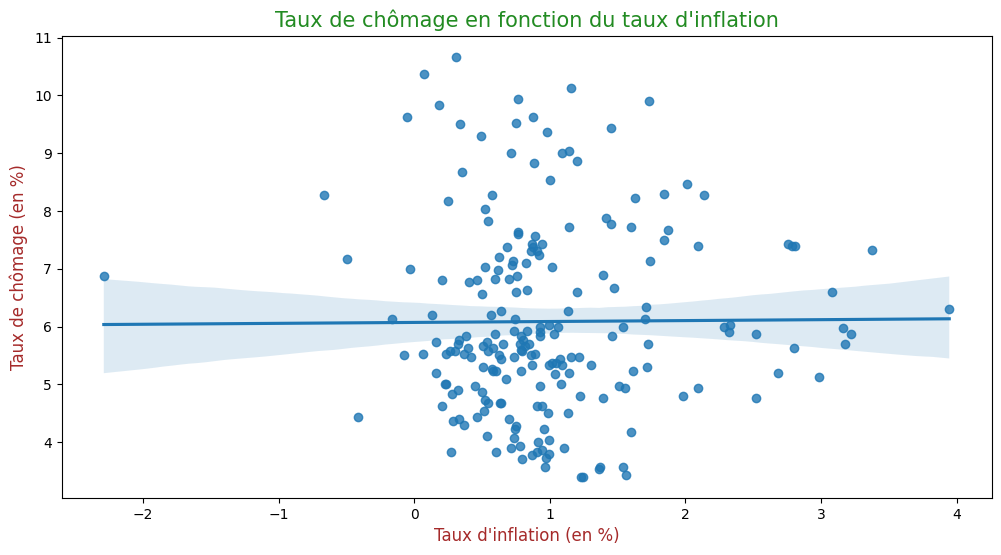

In [30]:
plt.figure(figsize=(12, 6))
sns.regplot(x=inf, y=unemp, ci=95)
plt.xlabel("Taux d'inflation (en %)", fontsize="12", color='brown')
plt.ylabel("Taux de chômage (en %)", fontsize=12, color='brown')
plt.title("Taux de chômage en fonction du taux d'inflation", fontsize=15, color='forestgreen')
plt.show()

On veut expliquer le taux de chômage en fonction du taux d'inflation.

In [31]:
X = np.array(inf[1:])
Y = np.array(unemp[1:])

model = sm.OLS(Y, sm.add_constant(X)).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.01214
Date:                Tue, 30 May 2023   Prob (F-statistic):              0.912
Time:                        00:58:35   Log-Likelihood:                -400.28
No. Observations:                 211   AIC:                             804.6
Df Residuals:                     209   BIC:                             811.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0708      0.181     33.576      0.0

In [32]:
print("Somme des carrés des résidus      : ", model.ssr)
print("Somme des carrés de la régression : ", model.ess)
print("Somme des carrés totaux           : ", model.ssr + model.ess)
print("\n")
print("Coefficient de détermination R2   : ", model.rsquared)

Somme des carrés des résidus      :  548.9801263315712
Somme des carrés de la régression :  0.0318784077651344
Somme des carrés totaux           :  549.0120047393364


Coefficient de détermination R2   :  5.806504682948077e-05


On ne peut pas conclure sur l’influence du taux d'inflation sur le chômage. Même si le coefficient associé au taux d'inflation est signficiatif (p-value = 0.912), cette influence est très faible (0.0159) en comparaison avec la constante (6.0708). On peut également voir ça sur le graphe ci-dessus.

### 10. Tester l’autocorrélation des erreurs.

In [33]:
# Valeurs prédites
Y_pred = model.predict(sm.add_constant(X))

# Résidus
residus = model.resid

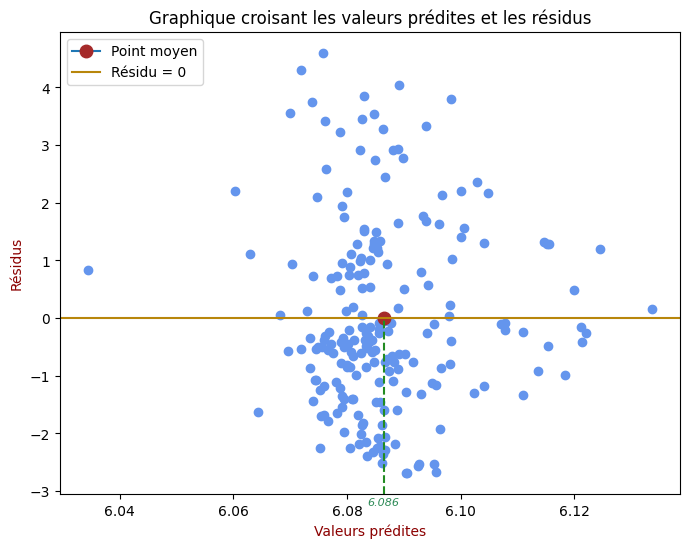

In [34]:
fig = plt.figure(figsize=(8,6))

plt.plot(Y_pred, residus, 'o', color="cornflowerblue")
plt.plot(Y.mean(), 0, marker='o', markersize=9, markeredgecolor='brown', markerfacecolor='brown', label="Point moyen")

plt.axhline(y=0, xmin=0, xmax=1, color='darkgoldenrod', label="Résidu = 0")

axes = plt.gca()
y_min, y_max = axes.get_ylim()

ymax = -y_min / (y_max-y_min)

plt.axvline(x=Y.mean(), ymin=0, ymax=ymax, linestyle='--', color='forestgreen')

plt.text(Y.mean()-0.003, y_min-0.2, str(round(Y.mean(),3)), fontstyle='italic', color='seagreen', fontsize=8)

plt.title("Graphique croisant les valeurs prédites et les résidus")
plt.xlabel("Valeurs prédites", color='darkred')
plt.ylabel("Résidus", color='darkred')

plt.legend(loc='upper left')

plt.show()

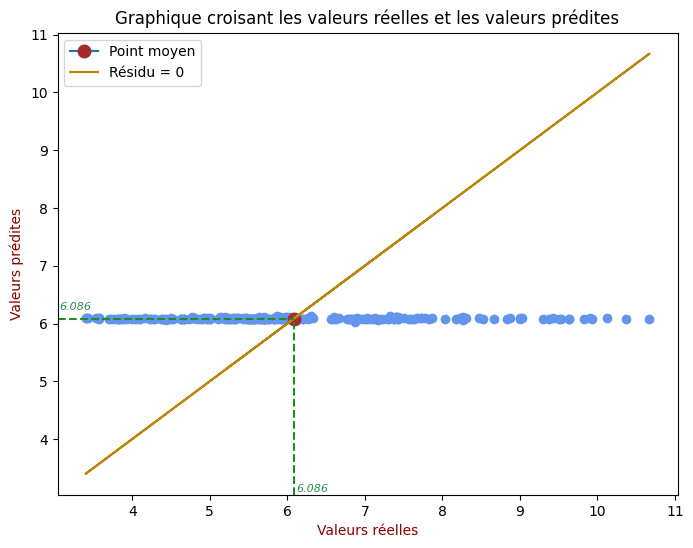

In [35]:
fig = plt.figure(figsize=(8,6))

plt.plot(Y, Y_pred, 'o', color="cornflowerblue")
plt.plot(Y.mean(), Y.mean(), marker='o', markersize=9, markeredgecolor='brown', markerfacecolor='brown', label="Point moyen")

plt.plot(Y, Y, color='darkgoldenrod', label="Résidu = 0")

axes = plt.gca()
x_min, x_max = axes.get_xlim()
y_min, y_max = axes.get_ylim()

xmax = (Y.mean()-x_min)/(x_max-x_min)
ymax = (Y.mean()-y_min)/(y_max-y_min)

plt.axhline(y=Y.mean(), xmin=0, xmax=xmax, linestyle='--', color='forestgreen')
plt.axvline(x=Y.mean(), ymin=0, ymax=ymax, linestyle='--', color='forestgreen')

plt.text(x_min+0.02, Y.mean()+0.15, str(round(Y.mean(),3)), fontstyle='italic', color='seagreen', fontsize=8)
plt.text(Y.mean()+0.03, y_min+0.05, str(round(Y.mean(),3)), fontstyle='italic', color='seagreen', fontsize=8)

plt.title("Graphique croisant les valeurs réelles et les valeurs prédites")
plt.xlabel("Valeurs réelles", color='darkred')
plt.ylabel("Valeurs prédites", color='darkred')

plt.legend(loc='upper left')

plt.show()

In [36]:
# Test de Breusch-Pagan ➜ H0 : Homoscédasticité des résidus

from statsmodels.stats.diagnostic import het_breuschpagan

_, p_value_breusch_pagan, _, _ = het_breuschpagan(model.resid, model.model.exog)

print("p-value =", p_value_breusch_pagan)

if p_value_breusch_pagan < 0.05:
    print("\n➜ Rejet de H0 au seuil de 5% : Hétéroscédasticité")
else:
    print("\n➜ Non-rejet de H0 au seuil de 5% : Homoscédasticité")

p-value = 0.18333629880712082

➜ Non-rejet de H0 au seuil de 5% : Homoscédasticité


Pour tester l'autocorrélation des erreurs, on va tester l'hypothèse : $H_0 : ρ = 0$ dans l'équation $ε_t = ρ.ε_{t-1} + u$. Si $ρ = 0$, alors les erreurs ne sont pas autocorrélées.

In [37]:
ε_t = residus[1:] # ε(t)
ε_t_1 = residus[:-1] # ε(t-1)

model_autocorrelation = sm.OLS(ε_t, sm.add_constant(ε_t_1)).fit()

print(model_autocorrelation.t_test(np.eye(len(model_autocorrelation.params))))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0122      0.023      0.521      0.603      -0.034       0.058
c1             0.9800      0.015     67.391      0.000       0.951       1.009


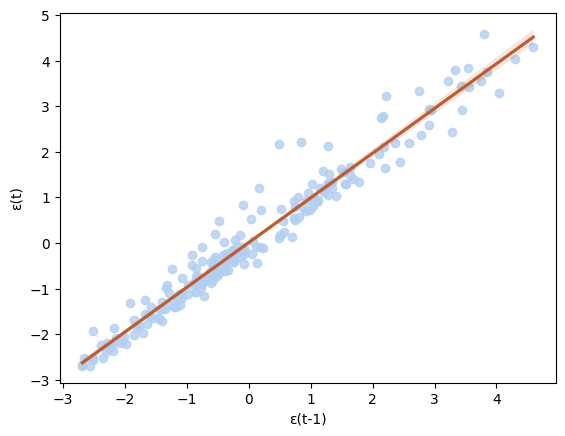

In [38]:
sns.regplot(x=ε_t_1, y=ε_t, ci=95, scatter_kws={"color": "#B2CFF1"}, line_kws={"color": "#BF5B2F"})
plt.xlabel("ε(t-1)")
plt.ylabel("ε(t)")
plt.show()

In [39]:
b = model_autocorrelation.params
params_std = model_autocorrelation.bse

n = len(ε_t) ### Nombre d'observations
p = len(b) ### Nombre de paramètres

t_score = b[1] / params_std[1]
p_value_t = stat.t.sf(abs(t_score), df=n-p)*2

print("t_score : ", t_score)
print("p-value : ", p_value_t)

if p_value_t < 0.05:
    print("\nRejet de H0 : Le coefficient ρ est significativement non nul au risque 5%")
else:
    print("\nAcceptation de H0 : Le coefficient ρ est significativement nul au risque 5%")

t_score :  67.39060033144462
p-value :  2.879310851430865e-143

Rejet de H0 : Le coefficient ρ est significativement non nul au risque 5%


On peut donc dire que les résidus sont autocorrélés car ρ ≠ 0 au risque 5%.

In [40]:
# Deuxième méthode : Test de Durbin-Watson
print("Test de Durbin-Watson : ", durbin_watson(residus))

Test de Durbin-Watson :  0.04419412807471203


Les résidus sont autocorrélés car le test de Durbin-Watson nous donne une valeur non proche à 2. On peut aussi avoir la valeur du test de Durbin-Watson par les deux méthodes suivantes :

In [41]:
durbin = np.sum((residus[1:] - residus[:-1])**2) / np.sum(residus[1:]**2)

print("Test de Durbin-Watson : ", durbin)

Test de Durbin-Watson :  0.04425236997779285


In [42]:
rho = model_autocorrelation.params[1]
durbin = 2*(1 - rho)

print("Test de Durbin-Watson : ", durbin)

Test de Durbin-Watson :  0.04007409265154904


En effet :

$$ DW = \frac{\sum{{ε_t - ε_{t-1}}^2}}{\sum{ε_t^2}} ≈ 2.(1 - \hat{ρ}) $$

### 11. Corriger l’autocorrélation des erreurs par la méthode vue en cours.

On applique le OLS sur les variables transformées :

$ \tilde{y_t} = y_t - \hat{ρ}.y_{t-1} $

$ \tilde{x_t} = x_t - \hat{ρ}.x_{t-1} $

In [43]:
# On définit nos variables
cpi = df['CPI']
t = np.array(range(1, len(cpi)+1))
inf = ((cpi.diff() / cpi.shift()) * 100.0).rename('INF')
unemp = df['Unemp']

# On calcule ρ
X = np.array(inf[1:])
Y = np.array(unemp[1:])

model_1 = sm.OLS(Y, sm.add_constant(X)).fit()

residus = model_1.resid

ε_t = residus[1:] # ε(t)
ε_t_1 = residus[:-1] # ε(t-1)

model_2 = sm.OLS(ε_t, sm.add_constant(ε_t_1)).fit()

rho = model_2.params[1]

# On transforme le X et le Y

X_trans = X[1:] - rho*X[:-1]
Y_trans = Y[1:] - rho*Y[:-1]

# On applique le OLS sur les variables transformées
model_3 = sm.OLS(Y_trans, sm.add_constant(X_trans)).fit()

print(model_3.t_test(np.eye(len(model_3.params))))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1361      0.023      5.899      0.000       0.091       0.182
c1            -0.0996      0.044     -2.281      0.024      -0.186      -0.014


On peut aussi appliquer le GLS (moindres carrés généralisés) en utilisant la matrice de corrélation des erreurs :

In [44]:
# On définit nos variables
cpi = df['CPI']
t = np.array(range(1, len(cpi)+1))
inf = ((cpi.diff() / cpi.shift()) * 100.0).rename('INF')
unemp = df['Unemp']

# On calcule ρ
X = np.array(inf[1:])
Y = np.array(unemp[1:])

model_1 = sm.OLS(Y, sm.add_constant(X)).fit()

residus = model_1.resid

ε_t = residus[1:] # ε(t)
ε_t_1 = residus[:-1] # ε(t-1)

model_2 = sm.OLS(ε_t, sm.add_constant(ε_t_1)).fit()

rho = model_2.params[1]

# Calcul de sigma (la matrice de corrélation des erreurs)
n = len(Y)
p = len(model_1.params)
var_epsilon = np.sum(residus**2) / (n - p)
sigma = var_epsilon * (rho**toeplitz(np.arange(n)))

# Appliquer le GLS
model_3= sm.GLS(Y, sm.add_constant(X), sigma=sigma).fit()

print(model_3.t_test(np.eye(len(model_3.params))))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             6.3115      0.949      6.652      0.000       4.441       8.182
c1            -0.0993      0.044     -2.277      0.024      -0.185      -0.013


### 12. Tester la stabilité de la relation chômage-inflation sur deux sous-périodes de taille identique.

Cela revient à faire le test de Chow de changement de structure.

Le test de Chow est un test statistique et économétrique afin de déterminer si les coefficients de deux séries linéaires sont égaux. Les coefficients sont établis par régression linéaire. Il est surtout utilisé dans le cadre de séries temporelles pour savoir s'il y a une cassure significative par une certaine date qui séparerait les données en deux blocs ; il permet également d'évaluer l'impact des variables indépendantes sur les deux groupes ainsi construits. Ce test s'appuie sur la loi de Fisher.

Si on sépare en deux groupes le modèle, on a :

➣ Pour le premier groupe : $unemp = β_{01} + β_{11}.inf + ε$

➣ Pour le deuxième groupe : $unemp = β_{02} + β_{12}.inf + ε$

L'hypothèse nulle du test de Chow nous dit que $β_{01} = β_{02}$, $β_{11} = β_{12}$. Ce qui veut dire qu'il n'y a pas de changement de structure dans notre série temporelle.

Soient $SSR$ la somme des carrés des résidus estimés du modèle initial, $SSR_1$ la somme des carrés des résidus estimés du premier groupe, et $SSR_2$ la somme des carrés des résidus estimés du groupe 2. Les valeurs $N_1$ et $N_2$ représentent le nombre d'observations dans chaque groupe et $k$ est le nombre total de paramétres à estimer (2 dans ce cas). Alors la statistique du test de Chow est égale à :

$$ F = \frac{\big(SSR - (SSR_1 + SSR_2)\big)~/~k}{(SSR_1 + SSR_2)~/~(N_1 + N_2 - 2k)} $$

Cette statistique du test suit une loi de Fisher avec $ν_1 = k$ et $ν_2 = N_1 + N_2 - 2k$ degrés de liberté.

In [45]:
# Modèle initial :
X = np.array(inf[1:])
Y = np.array(unemp[1:])

# Calcul de sigma
residus = sm.OLS(Y, sm.add_constant(X)).fit().resid
ε_t = residus[1:] # ε(t)
ε_t_1 = residus[:-1] # ε(t-1)
rho = sm.OLS(ε_t, sm.add_constant(ε_t_1)).fit().params[1]
var_epsilon = np.sum(residus**2) / (len(Y) - 2)
sigma = var_epsilon * (rho**toeplitz(np.arange(len(Y))))

# Le GLS pour corriger l'autocorrélation des résidus
model = sm.GLS(Y, sm.add_constant(X), sigma=sigma).fit()

Y_pred = model.predict(sm.add_constant(X)) # Valeurs prédites
b = model.params # Paramètres du modèle
SSR = model.ssr # Somme des carrés des résidus

print(model.t_test(np.eye(len(model.params))))
print("\nSSR =", SSR)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             6.3115      0.949      6.652      0.000       4.441       8.182
c1            -0.0993      0.044     -2.277      0.024      -0.185      -0.013

SSR = 223.494504050305


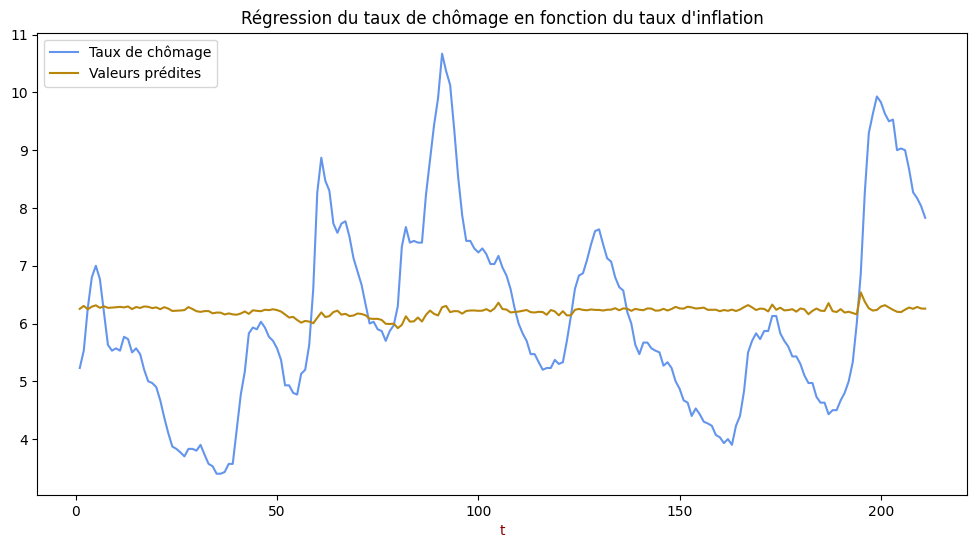

In [46]:
t = np.array(range(1, len(Y)+1))

fig = plt.figure(figsize=(12,6))

plt.plot(t, Y, label="Taux de chômage", color="cornflowerblue")
plt.plot(t, Y_pred, label="Valeurs prédites", color="darkgoldenrod")

plt.xlabel("t", color='darkred')

plt.title("Régression du taux de chômage en fonction du taux d'inflation")

plt.legend(loc='upper left')

plt.show()

In [47]:
N = len(Y)
N1 = N // 2
N2 = N - N1

print("N = ", N)
print("N1 = ", N1)
print("N2 = ", N2)

N =  211
N1 =  105
N2 =  106


In [48]:
# Modèle du premier groupe :
X1 = np.array(inf[1:])[:N1]
Y1 = np.array(unemp[1:])[:N1]

# Calcul de sigma
residus = sm.OLS(Y1, sm.add_constant(X1)).fit().resid
ε_t = residus[1:] # ε(t)
ε_t_1 = residus[:-1] # ε(t-1)
rho = sm.OLS(ε_t, sm.add_constant(ε_t_1)).fit().params[1]
var_epsilon = np.sum(residus**2) / (len(Y1) - 2)
sigma = var_epsilon * (rho**toeplitz(np.arange(len(Y1))))

# Le GLS pour corriger l'autocorrélation des résidus
model1 = sm.GLS(Y1, sm.add_constant(X1), sigma=sigma).fit()

Y_pred_1 = model1.predict(sm.add_constant(X1)) # Valeurs prédites
b1 = model1.params # Paramètres du modèle
SSR1 = model1.ssr # Somme des carrés des résidus

print(model1.t_test(np.eye(len(model1.params))))
print("\nSSR1 =", SSR1)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             6.3621      0.995      6.392      0.000       4.388       8.336
c1            -0.2607      0.078     -3.355      0.001      -0.415      -0.107

SSR1 = 85.7383764645018


In [49]:
# Modèle du deuxième groupe :
X2 = np.array(inf[1:])[N1:]
Y2 = np.array(unemp[1:])[N1:]

# Calcul de sigma
residus = sm.OLS(Y2, sm.add_constant(X2)).fit().resid
ε_t = residus[1:] # ε(t)
ε_t_1 = residus[:-1] # ε(t-1)
rho = sm.OLS(ε_t, sm.add_constant(ε_t_1)).fit().params[1]
var_epsilon = np.sum(residus**2) / (len(Y2) - 2)
sigma = var_epsilon * (rho**toeplitz(np.arange(len(Y2))))

# Le GLS pour corriger l'autocorrélation des résidus
model2 = sm.GLS(Y2, sm.add_constant(X2), sigma=sigma).fit()

Y_pred_2 = model2.predict(sm.add_constant(X2)) # Valeurs prédites
b2 = model2.params # Paramètres du modèle
SSR2 = model2.ssr # Somme des carrés des résidus

print(model2.t_test(np.eye(len(model2.params))))
print("\nSSR2 =", SSR2)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             6.4848      0.627     10.336      0.000       5.241       7.729
c1             0.0036      0.049      0.072      0.943      -0.094       0.102

SSR2 = 53.062649999043686


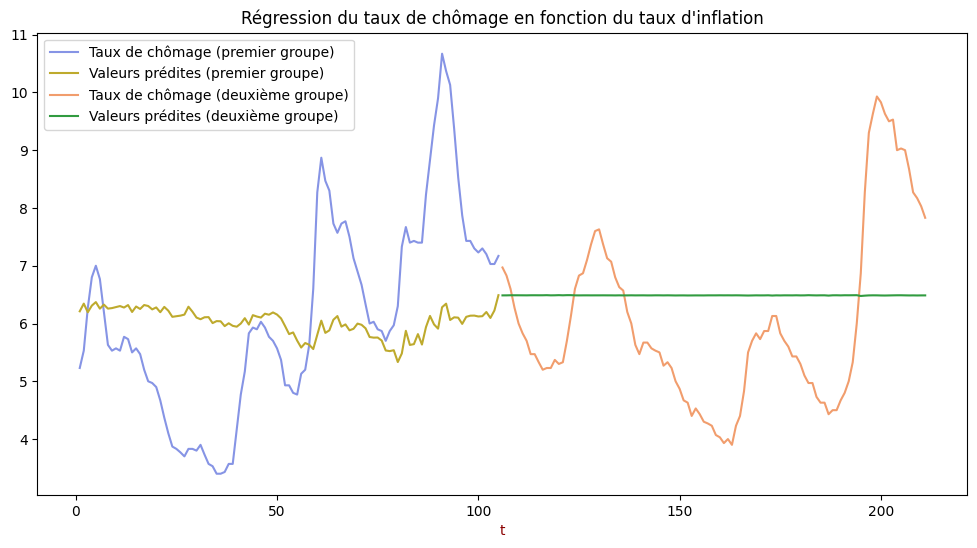

In [50]:
fig = plt.figure(figsize=(12,6))

plt.plot(t[:N1], Y1, label="Taux de chômage (premier groupe)", color="#8694E5")
plt.plot(t[:N1], Y_pred_1, label="Valeurs prédites (premier groupe)", color="#BEAA2D")

plt.plot(t[N1:], Y2, label="Taux de chômage (deuxième groupe)", color="#F19D6D")
plt.plot(t[N1:], Y_pred_2, label="Valeurs prédites (deuxième groupe)", color="#319B40")

plt.xlabel("t", color='darkred')

plt.title("Régression du taux de chômage en fonction du taux d'inflation")

plt.legend(loc='upper left')

plt.show()

In [51]:
k = 2 # Nombre de paramètres à estimer

f_score = ((SSR - (SSR1+SSR2)) / k) / ((SSR1+SSR2) / (N1+N2-2*k))
p_value_f = stat.f.sf(f_score, k, N1+N2-2*k)
print("f_score = "+str(round(f_score,5)))
print("p_value = "+str(round(p_value_f,5)))

if p_value_f < 0.05:
    print("\nRejet de H0, donc présence de changement de structure, au risque de 5%")
else:
    print("\nNon-rejet de H0, donc absence de changement de structure, au risque de 5%")

f_score = 63.15353
p_value = 0.0

Rejet de H0, donc présence de changement de structure, au risque de 5%


Au risque de 5%, il y a changement de structure entre les deux groupes considérés.

### 13. Estimer la courbe de Philips en supprimant l'inflation courante des variables explicatives mais en ajoutant les délais d’ordre 1, 2, 3 et 4 de l’inflation et du chômage. Faire le test de Granger de non causalité de l’inflation sur le chômage. Donnez la p-valeur.

In [52]:
cpi = df['CPI']
inf = ((cpi.diff() / cpi.shift()) * 100.0).rename('INF')
unemp = df['Unemp']

In [53]:
inf_shifted = pd.concat([inf.iloc[1:].shift(i) for i in range(1, 5)], axis=1)
unemp_shifted = pd.concat([unemp.iloc[1:].shift(i) for i in range(1, 5)], axis=1)

inf_shifted.columns = [f"INF_{i}" for i in range(1, 5)]
unemp_shifted.columns = [f"Unemp_{i}" for i in range(1, 5)]

pd.concat([inf_shifted, unemp_shifted], axis=1)

,INF_1,INF_2,INF_3,INF_4,Unemp_1,Unemp_2,Unemp_3,Unemp_4
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.578231,NaN,NaN,NaN,5.23,NaN,NaN,NaN
3,0.067636,0.578231,NaN,NaN,5.53,5.23,NaN,NaN
4,0.642109,0.067636,0.578231,NaN,6.27,5.53,5.23,NaN
5,0.201478,0.642109,0.067636,0.578231,6.80,6.27,5.53,5.23
...,...,...,...,...,...,...,...,...
207,0.716926,1.143990,1.088144,0.747672,9.00,9.03,9.00,9.53
208,0.349279,0.716926,1.143990,1.088144,8.67,9.00,9.03,9.00
209,0.572763,0.349279,0.716926,1.143990,8.27,8.67,9.00,9.03
210,0.249704,0.572763,0.349279,0.716926,8.17,8.27,8.67,9.00


In [54]:
pd.concat([inf_shifted, unemp_shifted], axis=1).iloc[4:]

,INF_1,INF_2,INF_3,INF_4,Unemp_1,Unemp_2,Unemp_3,Unemp_4
5,0.201478,0.642109,0.067636,0.578231,6.80,6.27,5.53,5.23
6,-0.033512,0.201478,0.642109,0.067636,7.00,6.80,6.27,5.53
7,0.402280,-0.033512,0.201478,0.642109,6.77,7.00,6.80,6.27
8,0.133556,0.402280,-0.033512,0.201478,6.20,6.77,7.00,6.80
9,0.400133,0.133556,0.402280,-0.033512,5.63,6.20,6.77,7.00
...,...,...,...,...,...,...,...,...
207,0.716926,1.143990,1.088144,0.747672,9.00,9.03,9.00,9.53
208,0.349279,0.716926,1.143990,1.088144,8.67,9.00,9.03,9.00
209,0.572763,0.349279,0.716926,1.143990,8.27,8.67,9.00,9.03
210,0.249704,0.572763,0.349279,0.716926,8.17,8.27,8.67,9.00


On a :

$$ unemp = a + β_1.inf_1 + β_2.inf_2 + β_3.inf_3 + β_4.inf_4 + α_1.unemp_1 + α_2.unemp_2 + α_3.unemp_3 + α_4.unemp_4 $$

On veut tester que : $inf$ ne cause pas $unemp$, en testant l'hypothèse : $β_1 = β_2 = β_3 = β_4 = 0$

In [55]:
# Modèle global
X1 = np.array(pd.concat([inf_shifted, unemp_shifted], axis=1).iloc[4:])
Y1 = np.array(unemp.iloc[5:])
model1 = sm.OLS(Y1, sm.add_constant(X1)).fit()

# Modèle contraint
X2 = np.array(pd.concat([inf_shifted, unemp_shifted], axis=1).iloc[4:,4:])
Y2 = np.array(unemp.iloc[5:])
model2 = sm.OLS(Y2, sm.add_constant(X2)).fit()

SSR1 = model1.ssr
SSR2 = model2.ssr

print("SSR (modèle global)    = ", SSR1)
print("SSR (modèle contraint) = ", SSR2)

SSR (modèle global)    =  11.587384278415238
SSR (modèle contraint) =  12.476148169307276


In [56]:
n = X1.shape[0] # Nombre d'observations
p = X1.shape[1] # Nombre de variables dans le modèle global (8)
q = X1.shape[1] - X2.shape[1] # Nombre de variables qu'on veut tester (4)

### Statistique de test :
f_score = ((SSR2-SSR1)/q) / (SSR1/(n-p-1)) # Suit une loi de Fisher de degrés de liberté (q, n-p-1)
p_value_f = stat.f.sf(f_score, q, n-p-1)

print("f_score : ", f_score)
print("p-value : ", p_value_f)

if p_value_f < 0.05:
    print("\n➜ Rejet de H0 au risque de 5%")
else:
    print("\n➜ Non-rejet de H0 au risque de 5%")

f_score :  3.7966991982053058
p-value :  0.005351957807936924

➜ Rejet de H0 au risque de 5%


La p-valeur du test de fisher est 0.005, on rejette l’hypothèse nulle de non-significativité globale des coefficients $β_i$. On peut ainsi dire au sens de Granger qu’il y a une relation de causalité de l'inflation sur le chômage.

### 14. Représentez graphiquement les délais distribués et commentez. Calculer l’impact à long de terme de l’inflation sur le chômage.

In [57]:
X = np.array(pd.concat([inf_shifted, unemp_shifted], axis=1).iloc[4:])
Y = np.array(unemp.iloc[5:])
model = sm.OLS(Y, sm.add_constant(X)).fit()

print(model.t_test(np.eye(len(model.params))))

coeff_inflation = model.params[1:5]
coeff_chomage = model.params[5:]

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1457      0.072      2.014      0.045       0.003       0.288
c1             0.0311      0.038      0.827      0.409      -0.043       0.105
c2            -0.0236      0.041     -0.577      0.565      -0.104       0.057
c3             0.0689      0.040      1.729      0.085      -0.010       0.148
c4             0.0163      0.038      0.435      0.664      -0.058       0.090
c5             1.5937      0.071     22.383      0.000       1.453       1.734
c6            -0.6472      0.134     -4.832      0.000      -0.911      -0.383
c7             0.0222      0.135      0.164      0.870      -0.245       0.289
c8            -0.0080      0.070     -0.114      0.910      -0.146       0.130


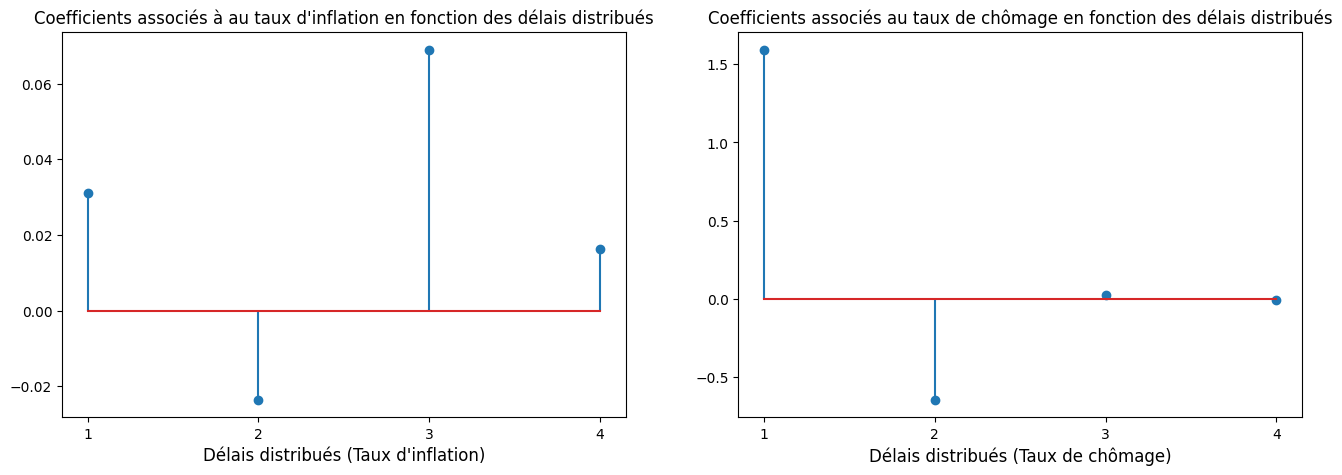

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].stem(range(1, 5), coeff_inflation)
ax[0].set_title("Coefficients associés à au taux d'inflation en fonction des délais distribués", fontsize=12)
ax[0].set_xlabel("Délais distribués (Taux d'inflation)", fontsize=12)
ax[0].set_xticks(range(1, 5))

ax[1].stem(range(1, 5), coeff_chomage)
ax[1].set_title("Coefficients associés au taux de chômage en fonction des délais distribués", fontsize=12)
ax[1].set_xlabel("Délais distribués (Taux de chômage)", fontsize=12)
ax[1].set_xticks(range(1, 5))

plt.show()

In [59]:
print("Somme des coefficients associés au taux d'inflation :", round(np.sum(coeff_inflation),4))
print("Somme des coefficients associés au taux de chômage :", round(np.sum(coeff_chomage),4))

Somme des coefficients associés au taux d'inflation : 0.0928
Somme des coefficients associés au taux de chômage : 0.9608


Si on considère que le taux de chômage reste stable sur 3 trimestres (donc $unemp_{t-1} = unemp_{t-2} = unemp_{t-3} = unemp_{t-4}$), on peut donc dire que, sur le long terme, le taux d'inflation n'a pas vraiment une influence sur le taux de chômage puisqu'une hausse de 1% sur le taux d'inflation entrainerait une hausse de 0.0928% du taux de chômage.

On retrouve donc le raisonnement explicatif derrière la courbe de Philips qui se fond sur l'idée que cette courbe est basée sur une boucle de rétroaction entre l'augmentation des embauches et l'augmentation des salaires.

C'est la raison pour laquelle nous avons eu toute à l'heure une droite de régression horizontale lorsqu'on a fait la régression du chômage en fonction du taux de l'inflation.